In [1]:
import matplotlib.image as matimg
import matplotlib.pyplot as plt
import numpy as np

In [58]:
64 / 2 ** 3

8.0

In [4]:
tuple = (1, 8, 8)

In [20]:
image = matimg.imread('mask_testing.jpg')

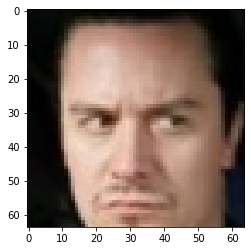

In [21]:
plt.imshow(image);

In [11]:
def mask_images(data, option='half'):
    valid_options = ('half', 'half random', '10 random', '20 random')
    multipliers = {'half': 0.5, 'half random': 0.5, '10 random': 0.9, '20 random': 0.8}
    if option not in valid_options:
        raise ValueError(f"Option must be one of: {valid_options}")
    real_img = data[0]
    img_size = real_img.shape[2]
    masked_img, real_part = real_img.clone(), real_img.clone()
    masking_equations = [2*117.0/255.0 - 1.0, 2*104.0/255.0 - 1.0, 2*123.0/255.0 - 1.0]
    if option == 'half':
        mask = np.zeros(real_img.shape[2:])
        mask[:int(img_size/2), :] = 1
        mask = mask.astype('bool') 
        for equation in masking_equations:
            masked_img[:, :, mask] = equation
            real_part[:, :, ~mask] = equation
    else:
        random_array = np.random.choice(2, int(img_size**2), p=[1 - multipliers[option], multipliers[option]])
        mask = random_array.reshape(real_img.shape[2:]).astype('bool')
        for equation in masking_equations:
            masked_img[:, :, mask] = equation
            real_part[:, :, ~mask] = equation
    return masked_img, real_part, mask

def resize_images(real_img):
    resize_images = real_img.clone()
    dim_size = int(resize_images.shape[2] / 4)
    resize_images = F.interpolate(resize_images, size=(dim_size, dim_size), mode='bilinear')
    return resize_images

In [7]:
import torchvision.transforms as transforms
import torch
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.nn.functional as F

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='C:\\Users\\Korisnik\\github\\PMFST-Sensor-Augmentation\\source\\data', transform=transform )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [3]:
torch.cuda.is_available()

False

In [12]:
data = next(iter(dataloader))
real_img = data[0]
masked_img, real_part, mask = mask_images(data, 'half random')
resized_img = resize_images(real_img)

c:\Users\Korisnik\github\PMFST-Sensor-Augmentation\.env\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


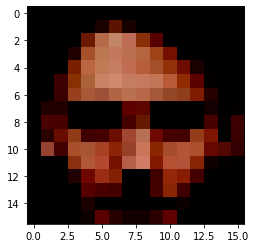

In [13]:
plt.imshow(resized_img[0].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


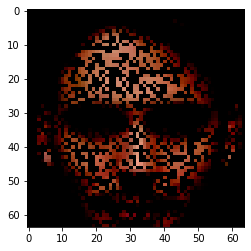

In [14]:
plt.imshow(masked_img[0].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


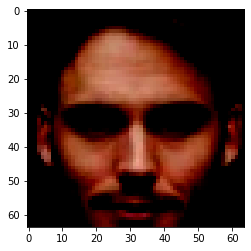

In [15]:
plt.imshow(real_img[0].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


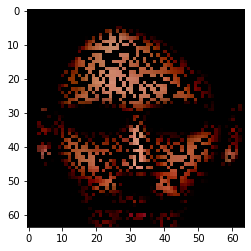

In [16]:
plt.imshow(real_part[0].permute(1, 2, 0));

In [51]:
patch_h, patch_w = int(64 / 2 ** 3), int(64 / 2 ** 3)
patch = (1, patch_h, patch_w)

valid = Variable(torch.FloatTensor(16, *patch).fill_(1.0), requires_grad=False)
fake = Variable(torch.FloatTensor(16, *patch).fill_(0.0), requires_grad=False)

In [41]:
label = torch.full((16, 1, 8, 8), 1, dtype=torch.float)

In [32]:
def apply_random_mask(img, mask_size):
    """Randomly masks image"""
    y1, x1 = np.random.randint(0, img.shape[0] - mask_size, 2)
    y2, x2 = y1 + mask_size, x1 + mask_size
    masked_part = img[y1:y2, x1:x2, :]
    masked_img = img.copy()
    masked_img[y1:y2, x1:x2, :] = 1
    return masked_img, masked_part

In [36]:
masked_image, masked_part = apply_random_mask(image, 16)

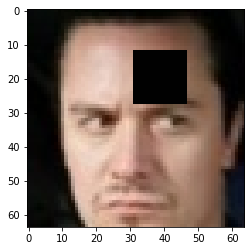

In [37]:
plt.imshow(masked_image);

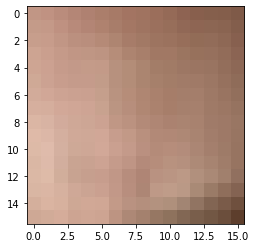

In [38]:
plt.imshow(masked_part);